In [8]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

zsh:1: 1.3.0 not found
zsh:1: no matches found: https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
--2025-11-30 15:50:05--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py
185.199.111.133, 185.199.108.133, 185.199.110.133, ...content.com)… 
соединение установлено.busercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 2879 (2,8K) [text/plain]
Сохранение в: «vocab.py»

vocab.py            100%[===================>]   2,81K  --.-KB/s    за 0s      

2025-11-30 15:50:05 (9,28 MB/s) - «vocab.py» сохранён [2879/2879]



In [12]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('/Users/ivanpaseka/Downloads/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|█████████████████████████████████████| 8000/8000 [00:02<00:00, 2827.78it/s]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [18]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [20]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


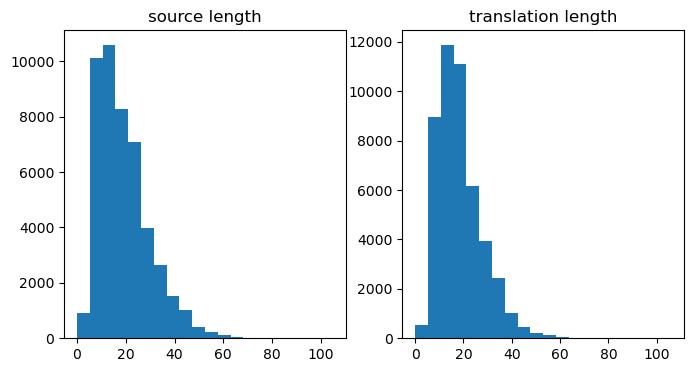

In [22]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [26]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        emb = self.emb_out(prev_tokens)                    # [batch, emb]
        new_dec_state0 = self.dec0(emb, prev_state[0])     # GRUCell
        output_logits = self.logits(new_dec_state0)        # [batch, vocab]
        new_dec_state = [new_dec_state0]

        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [28]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [30]:
print("Source:")
print('\n'.join([line for line in train_inp[:3]]))
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)

print("\nTranslations without training:")
print('\n'.join([line for line in dummy_translations]))

Source:
на территории обустроена бесплатная частная парковка .
кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .

Translations without training:
sco xin@@ disney ponte@@ anne climbing ça rovinj centre centre dral styles vets kun@@ 14 bicycl@@ tions fa queen@@ schö@@ june dish@@ igl@@ ziers belo
sco xin@@ disney ponte@@ anne climbing ça rovinj centre centre dral styles vets kun@@ 14 bicycl@@ tions fa queen@@ schö@@ june dish@@ igl@@ ziers belo
sco xin@@ disney ponte@@ anne climbing ça rovinj centre centre dral styles vets kun@@ 14 bicycl@@ tions fa queen@@ schö@@ june dish@@ igl@@ ziers belo


In [32]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)                                    # [B, T, V]

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = F.log_softmax(logits_seq, dim=-1)                # [B, T, V]
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy
    loss = -(logp_out * mask).sum() / mask.sum()
    # average cross-entropy over tokens where mask == True
    return loss # average loss, scalar

In [34]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.4796, grad_fn=<DivBackward0>)


In [36]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [38]:
compute_bleu(model, dev_inp, dev_out)

0.002054135723606187

In [40]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

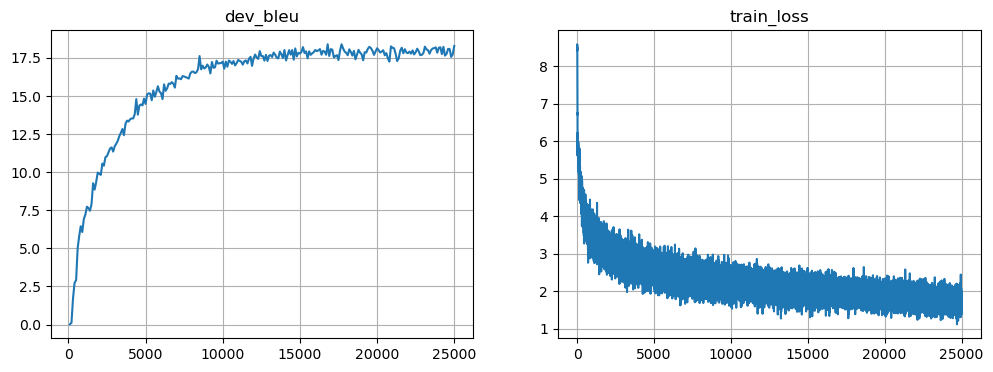

Mean loss=1.726


100%|█████████████████████████████████████| 25000/25000 [45:54<00:00,  9.08it/s]


In [42]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()                                   # обнуляем градиенты
    loss_t = compute_loss(model, batch_inp, batch_out)  # считаем loss на батче
    loss_t.backward()                                 # backprop
    opt.step()                                        # обновление весов

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)


In [44]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [46]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking and a ski storage room with free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the property is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of moscow , this self - catering accommodation is a 5 - minute walk from the beach , a kitchenette , a terrace and a garden with a sun terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartments az@@ ad@@ g offers accommodation in minsk , 12 - minute walk from the centre of thessaloniki .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a 

In [48]:
class DotProductAttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        """
        Scaled dot-product attention with projections
        :param enc_size: num units in encoder state
        :param dec_size: num units in decoder state
        :param hid_size: dimension of query/key space (d_k)
        """
        super().__init__()
        self.name = name
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size

        # Define projection layers
        # W_q, W_k, W_v project decoder states into query, key, value
        self.W_q = nn.Linear(dec_size, hid_size, bias=False)
        self.W_k = nn.Linear(enc_size, hid_size, bias=False)
        self.W_v = nn.Linear(enc_size, enc_size, bias=False)

    def forward(self, enc, dec, inp_mask):
        """
        Compute attention response and weights
        :param enc: encoder sequence [batch_size, ninp, enc_size]
        :param dec: decoder state [batch_size, dec_size]
        :param inp_mask: mask [batch_size, ninp] (0 = padding)
        :returns: attn [batch_size, enc_size], probs [batch_size, ninp]
        """

        # Compute Q, K, V projections
        Q = self.W_q(dec)                           # [B, hid]
        K = self.W_k(enc)                           # [B, T, hid]
        V = self.W_v(enc)                           # [B, T, enc]

        Q = Q.unsqueeze(1)                          # [B, 1, hid]

        # Compute logits as scaled dot product QK^T, do not forget 1 / d
        # Hint: You may want to expand Q to shape [batch_size, 1, hid_size]
        logits = (Q * K).sum(dim=-1) / (self.hid_size ** 0.5)   # [B, T]

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        mask = inp_mask == 0
        logits = torch.where(mask, torch.full_like(logits, -1e9), logits)

        # Softmax
        probs = F.softmax(logits, dim=-1)           # [B, T]

        # Compute attention response
        attn = torch.bmm(probs.unsqueeze(1), V).squeeze(1)  # [B, enc]

        return attn, probs

In [57]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # НЕ BasicModel.__init__, а именно nn.Module
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # эмбеддинги
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        # --- ВАЖНО: вот здесь как раз создаётся encoder ---
        self.encoder = nn.GRU(emb_size, hid_size, batch_first=True)

        # декодер будет получать [emb ; attn_vec]
        self.decoder = nn.GRUCell(emb_size + hid_size, hid_size)

        # attention-слой
        self.attn = DotProductAttentionLayer(
            "attn",
            enc_size=hid_size,
            dec_size=hid_size,
            hid_size=attn_size
        )

        # проекция из hidden в логиты по словарю
        self.logits = nn.Linear(hid_size, len(out_voc))

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)                      # [B, T, emb]
        enc_seq, _ = self.encoder(inp_emb)               # [B, T, H]

        # mask: 1 — там, где не EOS
        mask = (inp != self.inp_voc.eos_ix).float()      # [B, T]

        # начальное состояние декодера — нули
        dec_init = torch.zeros(inp.size(0),
                               self.hid_size,
                               device=inp.device)        # [B, H]

        # apply attention layer from initial decoder hidden state
        first_attn, first_attn_probas = self.attn(enc_seq, dec_init, mask)

        # Build first state:
        #  * dec hidden
        #  * encoder sequence
        #  * mask
        #  * attention probs (последний элемент списка!)
        first_state = [dec_init, enc_seq, mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        prev_h, enc_seq, mask, _ = prev_state            # распаковали состояние

        emb = self.emb_out(prev_tokens)                  # [B, emb]

        # attention по предыдущему состоянию декодера
        attn_vec, probs = self.attn(enc_seq, prev_h, mask)   # [B, H], [B, T]

        # вход в GRUCell: [emb ; attn]
        dec_input = torch.cat([emb, attn_vec], dim=-1)   # [B, emb+H]

        new_h = self.decoder(dec_input, prev_h)          # [B, H]

        output_logits = self.logits(new_h)               # [B, |V|]

        new_dec_state = [new_h, enc_seq, mask, probs]
        return new_dec_state, output_logits

In [59]:
attn_model = AttentiveModel(
    "attentive",
    inp_voc,
    out_voc,
    emb_size=64,
    hid_size=128,
    attn_size=128
).to(device)

attn_opt = torch.optim.Adam(attn_model.parameters(), lr=1e-3)

attn_metrics = {
    "train_loss": [],
    "dev_bleu": []
}

batch_size = 32

In [63]:
final_bleu = compute_bleu(attn_model, dev_inp, dev_out)
print("Final attentive BLEU:", final_bleu)

Final attentive BLEU: 22.995707469735503


In [65]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))
    show(fig)

Loading BokehJS ...

In [67]:
print("Source:")
print('\n'.join([line for line in train_inp[:3]]))
trans, states = model.translate_lines(train_inp[:3])

print("\nTranslations without training:")
print('\n'.join([line for line in trans]))

Source:
на территории обустроена бесплатная частная парковка .
кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .

Translations without training:
free private parking is available on site .
a variety of bars and restaurants can be found within a 5 - minute walk .
hotel casa de centro is located in the centre of trapani , just 100 metres from the cathedral .


In [71]:
inp = dev_inp[::500]
trans, states = model.translate_lines(inp)

attention_probs = np.stack(
    [state[-1].detach().cpu().numpy() for state in states[1:]],
    axis=1
)


In [73]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])